# Graduation Rate

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

In [2]:
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=0)
 
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1_score)

In [3]:
#create cross validation object
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [4]:
# Load in merged community college data
url = 'https://github.com/BrownRegaSterlingHeinen/PostsecondaryAttainment/blob/master/2016/Machine%20Learning%20Datasets/NCCCData_ML.csv?raw=true'
NCCCData = pd.read_csv(url)

In [5]:
# see what graduation rate variables are available
gradCols = NCCCData.columns[NCCCData.columns.str.lower().str.contains('completers')]
gradCols

Index(['Completers_150time_men', 'Completers_150time_women',
       'Completers_150time_American Indian or Alaska Native',
       'Completers_150time_Asian',
       'Completers_150time_Black or African American',
       'Completers_150time_Hispanic',
       'Completers_150time_Native Hawaiian or Other Pacific Islander',
       'Completers_150time_White', 'Completers_150time_Two or more races',
       'Completers_150time_Race/ethnicity unknown'],
      dtype='object')

In [6]:
# Bring back in grand total students column
url = 'https://github.com/BrownRegaSterlingHeinen/PostsecondaryAttainment/blob/master/2016/NCCC%20Datasets/mergedData.xlsx?raw=true'
oldData = pd.read_excel(url)

NCCCData['Grand total students'] = oldData['Grand total students']

In [7]:
#Get the median value of each variable in order to create two groups
NCCCData['gradRate'] = (NCCCData['Completers_150time_men']+NCCCData['Completers_150time_women'])/NCCCData['Grand total students']

grad_median=NCCCData['gradRate'].median()

#create high and low groups for each variable
NCCCData['gradRate_TwoGroups']=np.where(NCCCData['gradRate']<grad_median,"Low","High")

#get the 33rd and 66th percentiles for each variable
grad_33=np.percentile(NCCCData['gradRate'],33)
grad_66=np.percentile(NCCCData['gradRate'],66)

#split into three groups
NCCCData['gradRate_ThreeGroups']=pd.cut(NCCCData['gradRate'],[0,grad_33,grad_66,np.inf],labels=['low','medium','high'])

In [8]:
#Create data frame of target variables
target_variables=NCCCData[["gradRate", "gradRate_ThreeGroups", "gradRate_TwoGroups"]]

In [9]:
#Remove all the target variables from the data set
target_cols=["gradRate", "gradRate_ThreeGroups", "gradRate_TwoGroups", "Certificate_Men_Percent"]
targets_dropped=NCCCData.drop(target_cols,axis=1)
targets_dropped=targets_dropped.drop(gradCols,axis=1)

In [10]:
encoded_column_vector = label_binarize(target_variables['gradRate_TwoGroups'], classes=['Low','High']) # Low is 0, high is 1 - https://stackoverflow.com/questions/39187875/scikit-learn-script-giving-vastly-different-results-than-the-tutorial-and-gives
target_variables['gradRate_TwoGroups'] = np.ravel(encoded_column_vector) # Reshape array

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
#Split into train and test data
#Chose 75/25 train/test split
x_train, x_test, y_train, y_test=train_test_split(targets_dropped,target_variables,test_size=0.25, random_state=0)

print("The train data set shape is: ",x_train.shape)
print("The test data set shape is: ",x_test.shape)

The train data set shape is:  (44, 313)
The test data set shape is:  (15, 313)


In [12]:
#logistic regression baseline
log_reg=LogisticRegression().fit(x_train,y_train["gradRate_TwoGroups"])

print("The mean accuracy on test data is: ", log_reg.score(x_test,y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.6


In [13]:
y_pred_log_reg = log_reg.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_log_reg)

Accuracy:  0.6
Precision:  0.5454545454545454
Recall:  0.8571428571428571
F1 score:  0.6666666666666665


In [14]:
# Create adaboost classifer object
# https://www.datacamp.com/community/tutorials/adaboost-classifier-python
abc_log_reg = AdaBoostClassifier(n_estimators=100, base_estimator=LogisticRegression(), learning_rate=1)
# Train Adaboost Classifer
model = abc_log_reg.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_abc_log_reg = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_abc_log_reg)

Accuracy:  0.6
Precision:  0.5454545454545454
Recall:  0.8571428571428571
F1 score:  0.6666666666666665


In [15]:
# Create Gradient Booster classifier
# https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/
gbc_log_reg = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1)
# Train Adaboost Classifer
model = gbc_log_reg.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_gbc_log_reg = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_gbc_log_reg)

Accuracy:  0.6
Precision:  0.5555555555555556
Recall:  0.7142857142857143
F1 score:  0.6250000000000001


In [16]:
#logistic regression PCA
pca = PCA(.95)

pca.fit(x_train)
pca.n_components_

print("In this PCA model, 95% of the variance amounts to", pca.n_components_, "principal components.")

#create model
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

log_reg_pca = LogisticRegression()
log_reg_pca.fit(x_train_pca, y_train['gradRate_TwoGroups'])
print("The mean accuracy on test data is: ", log_reg_pca.score(x_test_pca, y_test['gradRate_TwoGroups']))

In this PCA model, 95% of the variance amounts to 3 principal components.
The mean accuracy on test data is:  0.6


In [17]:
#logistic regression grid search
log_reg_grid = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object 
regGridSearch = GridSearchCV(estimator=log_reg_grid
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

regGridSearch.fit(x_train,y_train['gradRate_TwoGroups'])

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   11.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [18]:
#Use the best parameters for our model
log_reg_grid = regGridSearch.best_estimator_

print("The mean accuracy on test data is: ", log_reg_grid.score(x_test, y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.6666666666666666


In [19]:
y_pred_log_reg_grid = log_reg_grid.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred_log_reg_grid = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_log_reg_grid)

Accuracy:  0.6666666666666666
Precision:  0.6
Recall:  0.8571428571428571
F1 score:  0.7058823529411764


In [20]:
# Create adaboost classifer object
abc_log_reg_grid = AdaBoostClassifier(n_estimators=50, base_estimator=log_reg_grid, learning_rate=1)
# Train Adaboost Classifer
model = abc_log_reg_grid.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_abc_log_reg_grid = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_abc_log_reg_grid)

Accuracy:  0.6
Precision:  0.5454545454545454
Recall:  0.8571428571428571
F1 score:  0.6666666666666665


In [21]:
#random forest baseline
rf=RandomForestClassifier().fit(x_train,y_train['gradRate_TwoGroups'])

print("The mean accuracy on test data is: ", rf.score(x_test,y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.4666666666666667


In [22]:
y_pred_rf = rf.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_rf)

Accuracy:  0.4666666666666667
Precision:  0.4444444444444444
Recall:  0.5714285714285714
F1 score:  0.5


In [23]:
# Create adaboost classifer object
abc_rf = AdaBoostClassifier(n_estimators=50, base_estimator=RandomForestClassifier(), learning_rate=1)
# Train Adaboost Classifer
model = abc_rf.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_abc_rf = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_abc_rf)

Accuracy:  0.7333333333333333
Precision:  0.6666666666666666
Recall:  0.8571428571428571
F1 score:  0.75


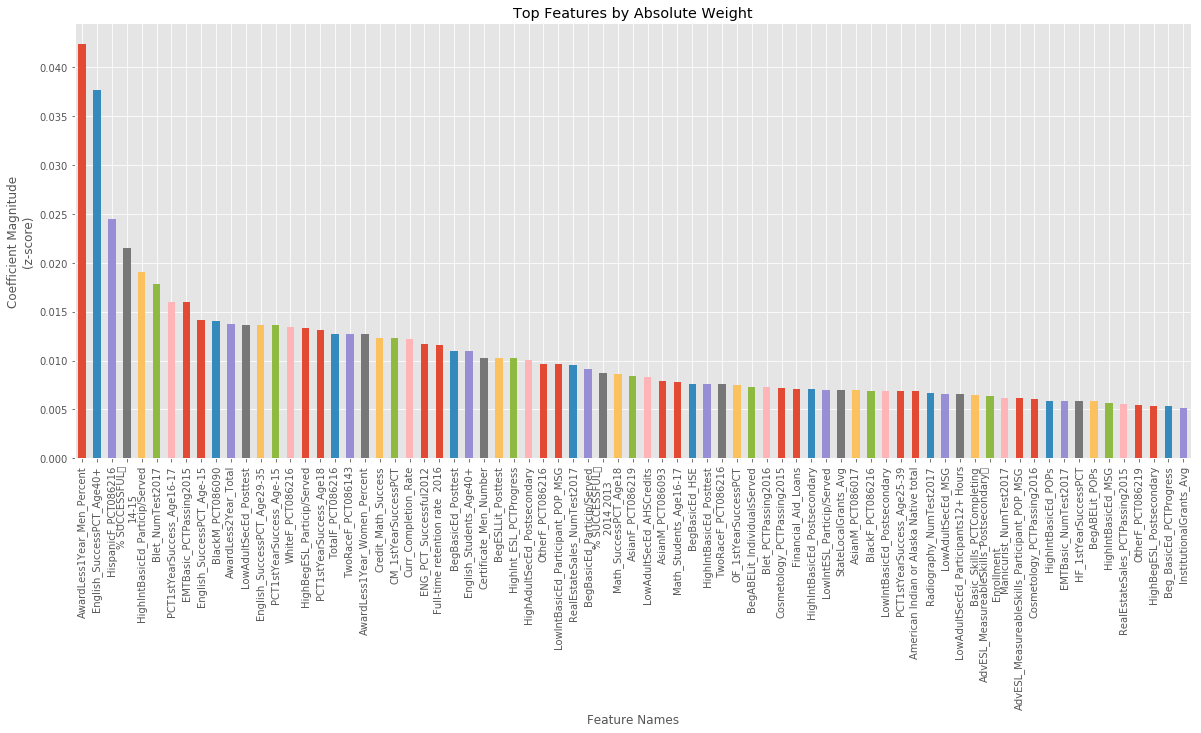

In [24]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
# Baseline RF model
#weights = rf.feature_importances_
# Adaboost RF model
weights = model.feature_importances_
feature_names = x_train.columns.values
rf_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
rf_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = rf_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [25]:
#random forest grid search
rf_grid=RandomForestClassifier()

parameters = { 'n_estimators': [1,5,10,15,20,25,30,35,40,45,50]
              ,'criterion': ['gini','entropy']
              ,'bootstrap': [True,False]
              }

regGridSearch = GridSearchCV(estimator=rf_grid
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_train, y_train['gradRate_TwoGroups'])

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 440 out of 440 | elapsed:   10.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_estimators': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [26]:
#Use the best parameters for our model
rf_grid = regGridSearch.best_estimator_

print("The mean accuracy on test data is: ", rf_grid.score(x_test, y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.6


In [27]:
y_pred_rf_grid = rf_grid.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_rf_grid)

Accuracy:  0.6
Precision:  0.6
Recall:  0.42857142857142855
F1 score:  0.5


In [44]:
# Create adaboost classifer object
abc_rf_grid = AdaBoostClassifier(n_estimators=100, base_estimator=rf_grid, learning_rate=1)
# Train Adaboost Classifer
model = abc_rf_grid.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_abc_rf_grid = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_abc_rf_grid)

Accuracy:  0.8
Precision:  0.7
Recall:  1.0
F1 score:  0.8235294117647058


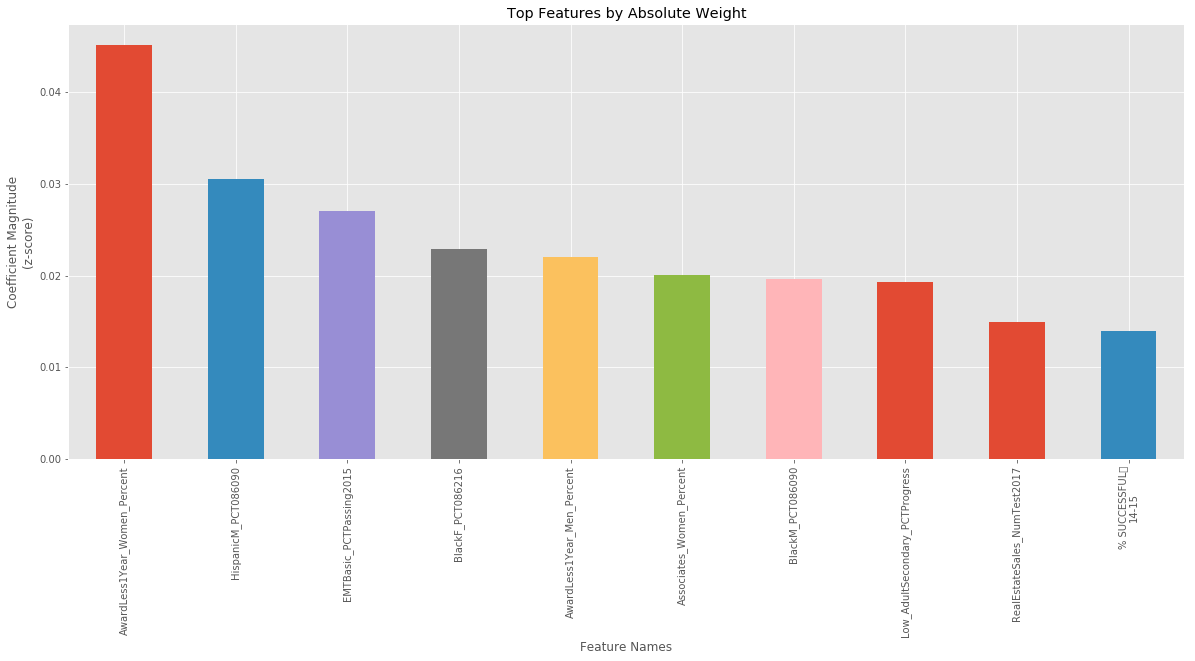

In [45]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
# RF grid model
#weights = rf.feature_importances_
# Adaboost RF grid model
weights = model.feature_importances_
feature_names = x_train.columns.values
rfgrid_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
rfgrid_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = rfgrid_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [30]:
#decision tree

dt=DecisionTreeClassifier().fit(x_train,y_train['gradRate_TwoGroups'])

print("The mean accuracy on test data is: ", dt.score(x_test, y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.4666666666666667


In [31]:
y_pred_dt = dt.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_dt)

Accuracy:  0.4666666666666667
Precision:  0.45454545454545453
Recall:  0.7142857142857143
F1 score:  0.5555555555555556


In [32]:
# Create adaboost classifer object
abc_dt = AdaBoostClassifier(n_estimators=50, base_estimator=DecisionTreeClassifier(), learning_rate=1)
# Train Adaboost Classifer
model = abc_dt.fit(x_train, y_train['gradRate_TwoGroups'])

#Predict the response for test dataset
y_pred_abc_dt = model.predict(x_test)
evaluate(y_test['gradRate_TwoGroups'], y_pred_abc_dt)

Accuracy:  0.4
Precision:  0.4
Recall:  0.5714285714285714
F1 score:  0.47058823529411764


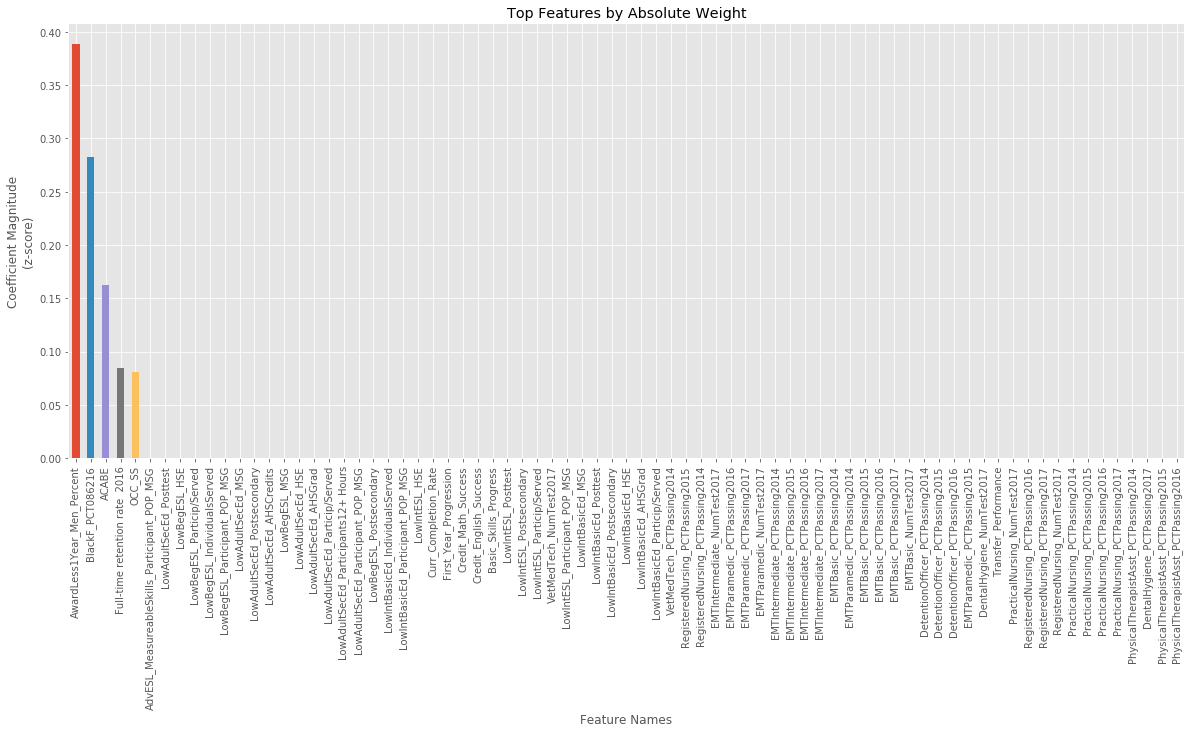

In [33]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = dt.feature_importances_
feature_names = x_train.columns.values
dt_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
dt_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = dt_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [34]:
#Nearest Centroid base line
nc = NearestCentroid().fit(x_train,y_train['gradRate_TwoGroups'])

print("The mean accuracy on test data is: ", nc.score(x_test, y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.6666666666666666


In [35]:
y_pred_nc = nc.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_nc)

Accuracy:  0.6666666666666666
Precision:  1.0
Recall:  0.2857142857142857
F1 score:  0.4444444444444445


In [36]:
#Nearest Centroid grid search
nc_grid = NearestCentroid()

parameters = { 'metric': ['euclidean','cosine','manhattan']
              ,'shrink_threshold': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
              }

regGridSearch = GridSearchCV(estimator=nc_grid
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x_train, y_train['gradRate_TwoGroups'])


Fitting 10 folds for each of 63 candidates, totalling 630 fits


/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:140: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metri

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=NearestCentroid(metric='euclidean', shrink_threshold=None),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'metric': ['euclidean', 'cosine', 'manhattan'], 'shrink_threshold': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [37]:
#Use the best parameters for our model
nc_grid = regGridSearch.best_estimator_

print("The mean accuracy on test data is: ", nc_grid.score(x_test, y_test['gradRate_TwoGroups']))

The mean accuracy on test data is:  0.7333333333333333


In [38]:
y_pred_nc_grid = nc_grid.predict(x_test)
#encoded = label_binarize(y_pred, classes=['Low','High']) # Low is 0, high is 1
#y_pred = np.ravel(encoded)
evaluate(y_test['gradRate_TwoGroups'], y_pred_nc_grid)

Accuracy:  0.7333333333333333
Precision:  0.6666666666666666
Recall:  0.8571428571428571
F1 score:  0.75


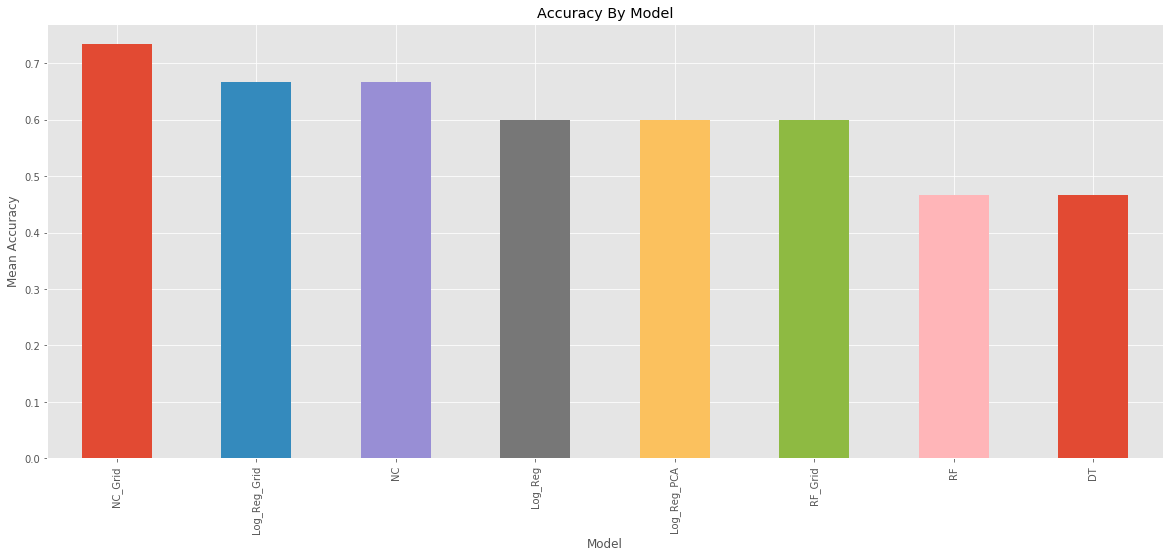

In [39]:
#graph every model's accuracy
log_reg_score=log_reg.score(x_test,y_test['gradRate_TwoGroups'])

log_reg_pca_score=log_reg_pca.score(x_test_pca, y_test['gradRate_TwoGroups'])

log_reg_grid_score=log_reg_grid.score(x_test, y_test['gradRate_TwoGroups'])

rf_score=rf.score(x_test,y_test['gradRate_TwoGroups'])

rf_grid_score=rf_grid.score(x_test, y_test['gradRate_TwoGroups'])

dt_score=dt.score(x_test, y_test['gradRate_TwoGroups'])

nc_score=nc.score(x_test, y_test['gradRate_TwoGroups'])

nc_grid_score=nc_grid.score(x_test, y_test['gradRate_TwoGroups'])

scores=pd.DataFrame({"Model":["Log_Reg","Log_Reg_PCA","Log_Reg_Grid","RF","RF_Grid","DT","NC","NC_Grid"]
                     ,"Accuracy":[log_reg_score,log_reg_pca_score,log_reg_grid_score,rf_score,rf_grid_score, dt_score,nc_score,nc_grid_score]})

scores.sort_values(by='Accuracy', inplace=True, ascending=False )

#print(scores)

%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

weights = pd.Series(scores["Accuracy"].values,index=scores["Model"])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Accuracy By Model")
ax.set_ylabel("Mean Accuracy")
ax.set_xlabel("Model")
plt.show()